In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

num_blocks_per_session = 12
num_trials_per_block = 24
num_trails_per_cond = 8

session1_blocks = [_ for _ in range(1, num_blocks_per_session+1)]
session2_blocks = [_ for _ in range(num_blocks_per_session+1, 2*num_blocks_per_session+1)]
session3_blocks = [_ for _ in range(2*num_blocks_per_session+1, 3*num_blocks_per_session+1)]
session4_blocks = [_ for _ in range(3*num_blocks_per_session+1, 4*num_blocks_per_session+2)]


In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    rcParams["font.size"] = 10  # General font size
    # rcParams["font.size"] = 20  # General font size
    rcParams["axes.titlesize"] = 12  # Figure title
    # rcParams["axes.titlesize"] = 26  # Figure title
    rcParams["axes.labelsize"] = 9  # Axis main label
    # rcParams["axes.labelsize"] = 22  # Axis main label
    rcParams["xtick.labelsize"] = 7  # Tick labels
    # rcParams["xtick.labelsize"] = 16  # Tick labels
    rcParams["ytick.labelsize"] = 7
    # rcParams["ytick.labelsize"] = 16
    rcParams["legend.fontsize"] = 8  # Legend entries
    # rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    rcParams["axes.linewidth"] = 0.75
    # rcParams["axes.linewidth"] = 1.5

    # rcParams["lines.linewidth"] = 3
    
    rcParams["xtick.major.width"] = 0.75
    # rcParams["xtick.major.width"] = 1.5
    rcParams["ytick.major.width"] = 0.75
    # rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [3]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

subjs['day'] = subjs.apply(utils.add_day, axis=1)

In [5]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'S': sns.color_palette('colorblind')[7],
    'M+S': sns.color_palette('colorblind')[1],
    'M+S (changed)': sns.color_palette('colorblind')[3]
}



In [7]:
subjs.columns
subjs[['precueTime','RT', 'ET', 'MT', 'pressTime1', 'pressTime2', 'pressTime3', 
            'pressTime4', 'pressTime5', 'pressTime6', 
            'pressTime7', 'trialDur']]

,precueTime,RT,ET,MT,pressTime1,pressTime2,pressTime3,pressTime4,pressTime5,pressTime6,pressTime7,trialDur
0,876,860,2915,2055,1740,1970,2275,2555,2980,3395,3670,7010
1,686,585,3555,2970,1275,1725,2115,2640,3140,3625,4105,7460
2,710,785,2545,1760,1495,1760,2025,2335,2615,2870,3125,6470
3,935,1760,5530,3770,2695,3175,3575,4280,4725,5875,6305,9680
4,718,735,3120,2385,1455,1675,1890,2885,3150,3460,3710,7055
...,...,...,...,...,...,...,...,...,...,...,...,...
12091,870,825,2815,1990,1695,1980,2210,2435,2825,3235,3445,6900
12092,705,925,2880,1955,1630,1760,2170,2420,2745,3050,3390,6800
12093,676,535,2590,2055,1215,1395,1675,1955,2155,2780,2985,6485
12094,824,925,2745,1820,1750,1900,2135,2485,2740,3105,3315,6785


In [8]:
# sum of  all IPIs in a trial
subjs['sum_IPI'] = subjs['IPI1'] + subjs['IPI2'] + subjs['IPI3'] + subjs['IPI4'] + subjs['IPI5'] + subjs['IPI6']
subjs[['MT', 'sum_IPI']]

,MT,sum_IPI
0,2055,1930
1,2970,2830
2,1760,1630
3,3770,3610
4,2385,2255
...,...,...
12091,1990,1750
12092,1955,1760
12093,2055,1770
12094,1820,1565


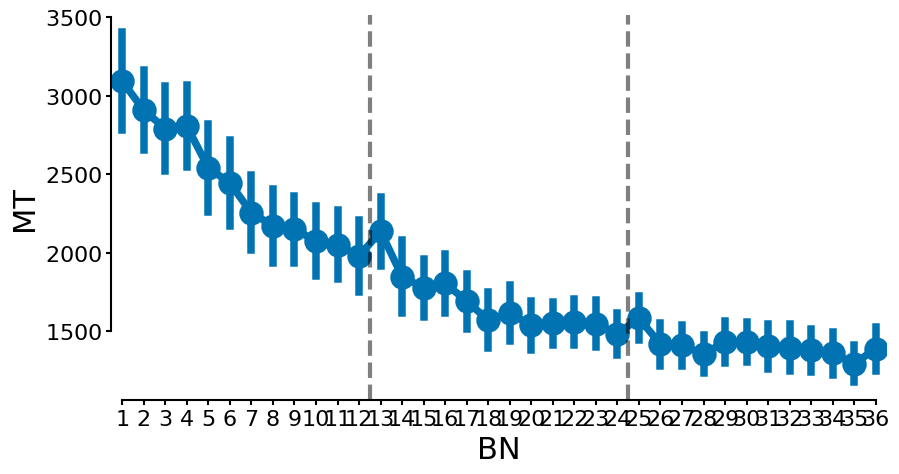

In [24]:
plt.figure(figsize=(10, 5))
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', errorbar='se', hue = 0,
              palette='colorblind', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

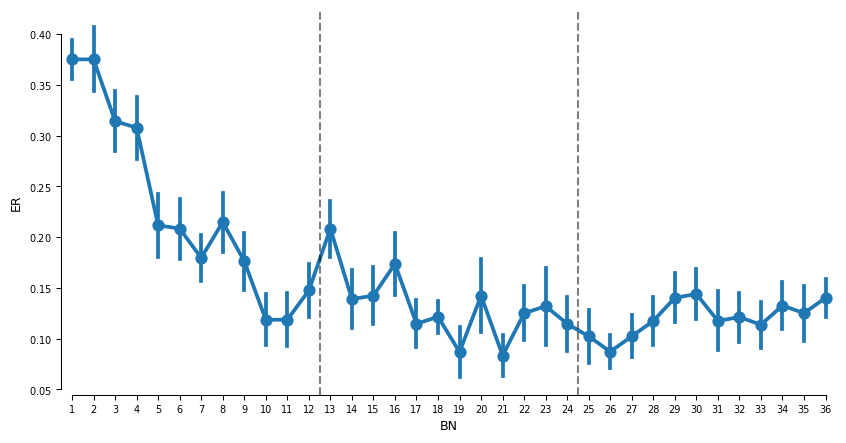

In [50]:
plt.figure(figsize=(10, 5))

subjs_grouped = subjs.groupby(['BN', 'SubNum']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trials_per_block 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue =0, errorbar='se', legend=False)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

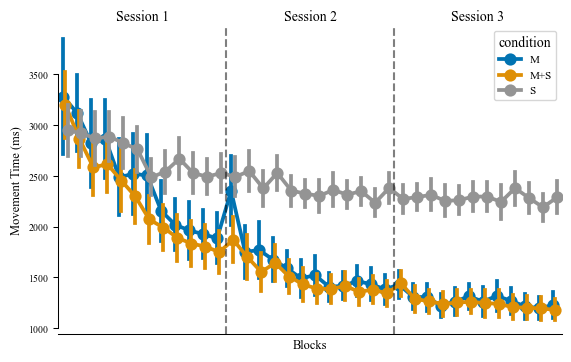

In [6]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="2col")

subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette=custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)


# add text labels for sessions
plt.text(5.5, 4000, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 4000, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 4000, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
plt.ylabel('Movement Time (ms)')

sns.despine(trim=True)

plt.savefig(path_figs + "MT_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

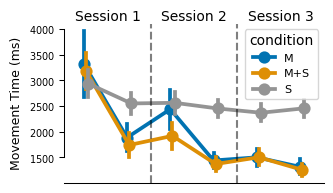

In [196]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="1col")

included_BNs = [session1_blocks[0], session1_blocks[-1], session2_blocks[0], session2_blocks[-1], session3_blocks[0], session3_blocks[-1]]

subjs_correct = utils.remove_error_trials(subjs)
subjs_correct = subjs_correct[subjs_correct['BN'].isin(included_BNs)]

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.1, palette=custom_palette)
plt.axvline(x=1.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=3.5, color='black', linestyle='--', alpha = 0.5)

# add text labels for sessions
plt.text(0.5, 4100, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(2.5, 4100, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(4.5, 4100, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
plt.ylabel('Movement Time (ms)')


sns.despine(trim=True)



plt.savefig(path_figs + "MT_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

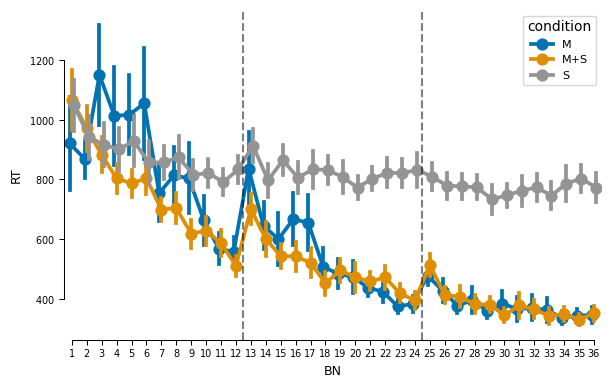

In [96]:
set_figure_style(scale="2col")

subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['BN', 'SubNum', 'condition']).agg({
    'RT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'RT', hue = 'condition', errorbar='se',
              dodge = 0.3, palette=custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)
sns.despine(trim=True)

plt.show()

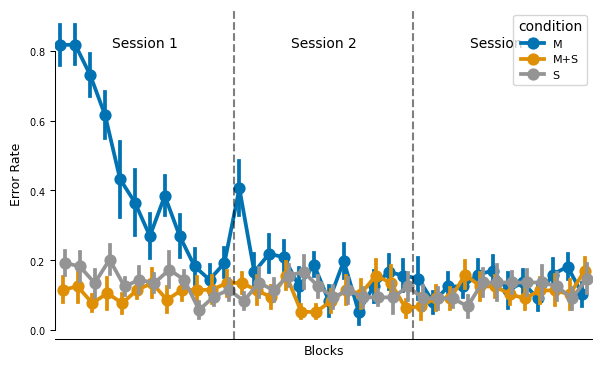

In [7]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="2col")
subjs_grouped = subjs.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
              errorbar='se', dodge = 0.3, palette= custom_palette)
plt.axvline(x=11.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=23.5, color='black', linestyle='--', alpha = 0.5)

# add text labels for sessions
plt.text(5.5, 0.8, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 0.8, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 0.8, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
plt.ylabel('Error Rate')

sns.despine(trim=True)

plt.savefig(path_figs + "ER_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

In [60]:
subjs_grouped

,isStartBlocks,SubNum,condition,isError,ER
0,False,1,M,5,0.625
1,False,1,S,10,1.250
2,False,2,M,11,1.375
3,False,2,S,4,0.500
4,False,3,M,1,0.125
5,False,3,S,2,0.250
6,False,4,M,5,0.625
7,False,4,S,5,0.625
8,False,5,M,5,0.625
9,False,5,S,4,0.500


In [16]:
fig_height

4.0147898901795696

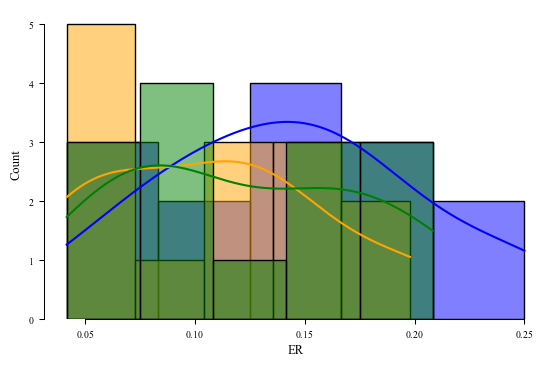

In [35]:
set_figure_style(scale = "2col")



# ---- Error Rate ----
### statistical test to show no ER difference in day 2 and day 3
second_and_last_day = subjs[subjs['BN'].isin(session3_blocks)].copy()
# merge S and M+S conditions
# second_and_last_day['condition'] = second_and_last_day['condition'].replace({'S': 'S', 'M+S': 'S'})
                                                                            
subjs_grouped = second_and_last_day.groupby(['SubNum', 'condition']).agg({
    'isError': ['sum', 'count']
    # 'isError': 'sum'
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError']['sum'] / subjs_grouped['isError']['count']
# print(subjs_grouped)

# plot histogram of ER difference between M and M+S conditions
sns.histplot(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], kde=True, color='blue', label='M')
sns.histplot(subjs_grouped[subjs_grouped['condition'] == 'M+S']['ER'], kde=True, color='orange', label='M+S')
sns.histplot(subjs_grouped[subjs_grouped['condition'] == 'S']['ER'], kde=True, color='green', label='S')


#chi-square test 

# print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'M+S']['ER']))
# print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'S']['ER']))

# res = AnovaRM(subjs_grouped[['ER', 'SubNum', 'condition']], 'ER', 'SubNum', within=['condition']).fit()
# print(res)

#chi-square test 
# make a contingency table having count of error for each condition
# contingency_table = pd.pivot_table(subjs_grouped, columns='condition', index='SubNum', values='isError', aggfunc='sum')
# print(contingency_table)
# chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
# print(f"Chi-square test: chi2 = {chi2}, p-value = {p}, dof = {dof}")



sns.despine(trim=True)

# plt.savefig(path_figs + "MT_and_Error_sessions.pdf", format = 'pdf', bbox_inches = 'tight')


TtestResult(statistic=-6.130252405976642, pvalue=3.60036761148398e-05, df=13)
                         F Value  Num DF  Den DF        Pr > F
isFirstDay             40.333451     1.0    13.0  2.532169e-05
condition             252.709794     1.0    13.0  6.730100e-10
isFirstDay:condition   22.941104     1.0    13.0  3.533166e-04
TtestResult(statistic=2.0228167093470253, pvalue=0.06416020628081263, df=13)
TtestResult(statistic=7.0238915408137705, pvalue=9.014168306602434e-06, df=13)


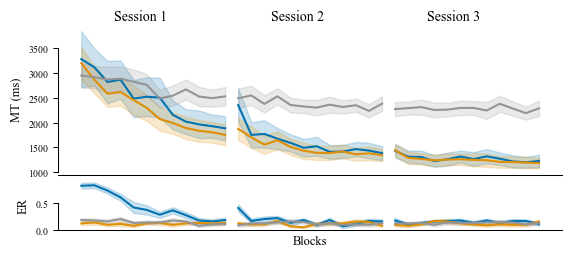

In [13]:
set_figure_style(scale = "2col")

#get height of figure
fig = plt.figure()
fig.canvas.draw()
fig_height = fig.get_figheight()
fig_width = fig.get_figwidth()
fig.clear()
plt.close(fig)

fig = plt.figure(figsize=(fig_width, fig_height * 1/1.5))


gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)



# ---- Movement Time ----
subjs_correct = utils.remove_error_trials(subjs)

for day, day_data in subjs_correct.groupby('day'):


    subjs_grouped = day_data.groupby(['BN', 'day','SubNum', 'condition']).agg({
        'MT': 'median'
    }).reset_index()

    # sns.pointplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
    #               dodge = 0.3, palette=custom_palette, ax=plt.subplot(gs[0]))

    sns.lineplot(data = subjs_grouped, x = 'BN', y = 'MT', hue = 'condition', errorbar='se',
                palette=custom_palette, ax=plt.subplot(gs[0]), legend=False)


#### statistical test
# day1 = subjs_correct[subjs_correct['BN'].isin(session1_blocks)].copy()
# # extracting first three and last three blocks of each session
# day1 = day1[(day1['BN'].isin(session1_blocks[:3])) | (day1['BN'].isin(session1_blocks[-3:]))]
# #add column for start and end of session
# day1['isStartBlocks'] = day1['BN'].isin(session1_blocks[:3])
# # merge M and M+S conditions
# day1['condition'] = day1['condition'].replace({'M': 'M+S', 'M+S': 'M+S'})

# subjs_grouped = day1.groupby(['isStartBlocks', 'SubNum', 'condition']).agg({
#     'MT': 'median'
# }).reset_index()
# res = AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['isStartBlocks', 'condition']).fit()
# print(res.anova_table)



# comparing random and repeating in first day
day1 = subjs_correct[subjs_correct['BN'].isin(session1_blocks)].copy()
subjs_grouped = day1.groupby(['SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()
# print(subjs_grouped)
print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M+S']['MT'], subjs_grouped[subjs_grouped['condition'] == 'S']['MT']))

# extracting first and last sessions
first_and_last_day = subjs_correct[subjs_correct['BN'].isin(session1_blocks + session3_blocks)].copy()
# merge M and M+S conditions
first_and_last_day['condition'] = first_and_last_day['condition'].replace({'M': 'M+S', 'M+S': 'M+S'})
# add column for first or last session
first_and_last_day['isFirstDay'] = first_and_last_day['BN'].isin(session1_blocks)

subjs_grouped = first_and_last_day.groupby(['isFirstDay', 'SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()
res = AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['isFirstDay', 'condition']).fit()
print(res.anova_table)






# AnovaRM(day1, 'MT', 'SubNum', within=['condition', 'BN']).fit()





# add text labels for sessions
plt.text(5.5, 4000, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(17.5, 4000, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(29.5, 4000, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')


#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
# plt.ylabel('Movement Time (ms)')
plt.ylabel('MT (ms)')

# ---- Error Rate ----

for day, day_data in subjs.groupby('day'):

    subjs_grouped = day_data.groupby(['BN', 'SubNum', 'condition']).agg({
        'isError': 'sum'
    }).reset_index()
    subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

    # sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
    #               errorbar='se', dodge = 0.3, palette= custom_palette, ax=plt.subplot(gs[1]))
    sns.lineplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition',
                errorbar='se', palette=custom_palette, ax=plt.subplot(gs[1]), legend=False)



### statistical test
day1 = subjs[subjs['BN'].isin(session1_blocks)].copy()
# extracting first three and last three blocks of each session
day1 = day1[(day1['BN'].isin(session1_blocks[:3])) | (day1['BN'].isin(session1_blocks[-3:]))]
#add column for start and end of session
day1['isStartBlocks'] = day1['BN'].isin(session1_blocks[:3])
# merge S and M+S conditions
day1['condition'] = day1['condition'].replace({'S': 'S', 'M+S': 'S'})
subjs_grouped = day1.groupby(['isStartBlocks', 'SubNum', 'condition']).agg({
    'isError': ['sum', 'count']
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError']['sum']/ subjs_grouped['isError']['count']
# print(subjs_grouped)



# res = AnovaRM(subjs_grouped, 'ER', 'SubNum', within=['isStartBlocks', 'condition']).fit()
# print(res.anova_table)
first_blocks = subjs_grouped[subjs_grouped['isStartBlocks'] == True]
last_blocks = subjs_grouped[subjs_grouped['isStartBlocks'] == False]
# print(stats.ttest_rel(first_blocks[first_blocks['condition'] == 'M']['ER'], first_blocks[first_blocks['condition'] == 'S']['ER']))
# print(stats.ttest_rel(first_blocks[first_blocks['condition'] == 'M']['ER'], first_blocks[first_blocks['condition'] == 'M+S']['ER']))

# print(stats.ttest_rel(last_blocks[last_blocks['condition'] == 'M']['ER'], last_blocks[last_blocks['condition'] == 'S']['ER']))
# print(stats.ttest_rel(last_blocks[last_blocks['condition'] == 'M']['ER'], last_blocks[last_blocks['condition'] == 'M+S']['ER']))


### statistical test to show no ER difference in day 2 and day 3
second_and_last_day = subjs[subjs['BN'].isin(session3_blocks)].copy()
# merge S and M+S conditions
second_and_last_day['condition'] = second_and_last_day['condition'].replace({'S': 'S', 'M+S': 'S'})
                                                                            
subjs_grouped = second_and_last_day.groupby(['SubNum', 'condition']).agg({
    'isError': ['sum', 'count']
    # 'isError': 'sum'
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError']['sum'] / subjs_grouped['isError']['count']
# print(subjs_grouped)



#chi-square test 

# print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'M+S']['ER']))
print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'S']['ER']))

# print(stats.wilcoxon(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'M+S']['ER']))

# res = AnovaRM(subjs_grouped[['ER', 'SubNum', 'condition']], 'ER', 'SubNum', within=['condition']).fit()
# print(res)

#chi-square test 
# make a contingency table having count of error for each condition
# contingency_table = pd.pivot_table(subjs_grouped, columns='condition', index='SubNum', values='isError', aggfunc='sum')
# print(contingency_table)
# chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
# print(f"Chi-square test: chi2 = {chi2}, p-value = {p}, dof = {dof}")




first_day = subjs[subjs['BN'].isin(session1_blocks)].copy()
# merge S and M+S conditions
first_day['condition'] = first_day['condition'].replace({'S': 'S', 'M+S': 'S'})
                                                                            
subjs_grouped = first_day.groupby(['SubNum', 'condition']).agg({
    'isError': ['sum', 'count']
    # 'isError': 'sum'
}).reset_index()
subjs_grouped['ER'] = subjs_grouped['isError']['sum'] / subjs_grouped['isError']['count']
# print(subjs_grouped)
print(stats.ttest_rel(subjs_grouped[subjs_grouped['condition'] == 'M']['ER'], subjs_grouped[subjs_grouped['condition'] == 'S']['ER']))


#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('Blocks')
# plt.ylabel('Error Rate')
plt.ylabel('ER')
# plt.legend()

sns.despine(trim=True)

plt.savefig(path_figs + "MT_and_Error_sessions.pdf", format = 'pdf', bbox_inches = 'tight')


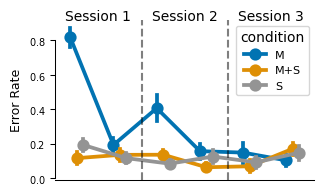

In [143]:
# plt.figure(figsize=(10, 5))
set_figure_style(scale="1col")

included_BNs = [session1_blocks[0], session1_blocks[-1], session2_blocks[0], session2_blocks[-1], session3_blocks[0], session3_blocks[-1]]

subjs_bns = subjs[subjs['BN'].isin(included_BNs)]

subjs_grouped = subjs_bns.groupby(['BN', 'SubNum', 'condition']).agg({
    'isError': 'sum'
}).reset_index()

subjs_grouped['ER'] = subjs_grouped['isError']/ num_trails_per_cond 

sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ER', hue ='condition', 
              errorbar='se', dodge = 0.3, palette= custom_palette)
plt.axvline(x=1.5, color='black', linestyle='--', alpha = 0.5)
plt.axvline(x=3.5, color='black', linestyle='--', alpha = 0.5)

# # add text labels for sessions
plt.text(0.5, 0.9, 'Session 1', fontsize=10, ha = 'center', va = 'bottom')
plt.text(2.5, 0.9, 'Session 2', fontsize=10, ha = 'center', va = 'bottom')
plt.text(4.5, 0.9, 'Session 3', fontsize=10, ha = 'center', va = 'bottom')

#removing x axis ticks and labels
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.xlabel('')
plt.ylabel('Error Rate')


sns.despine(trim=True)

plt.savefig(path_figs + "ER_sessions.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

### Horizon Effect:

In [ ]:
set_figure_style(scale="2col")
plt.gcf().get_size_inches()



fig, axs = plt.subplots(1, 3)


array([6.9291376 , 4.28244255])

<Figure size 692.914x428.244 with 0 Axes>

Session 1 ANOVA                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
windowSize           112.7562 3.0000 39.0000 0.0000
condition             44.5628 1.0000 13.0000 0.0000
windowSize:condition  25.9128 3.0000 39.0000 0.0000

Session 1 paired t-test between window sizes 1 and 2 t-stat: 14.819777059759538, p-value: 1.6023899497002755e-09
Session 1 paired t-test between window sizes 2 and 3 t-stat: 3.531981969694983, p-value: 0.0036813082393711157
Session 1 paired t-test between window sizes 3 and 7 t-stat: 0.13275430257193366, p-value: 0.896420562160037
Session 2 ANOVA                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
windowSize           299.6377 3.0000 39.0000 0.0000
condition            299.0250 1.0000 13.0000 0.0000
windowSize:condition 143.2329 3.0000 39.0000 0.0000

Session 2 paired t-test between window sizes 1 and 2 t-

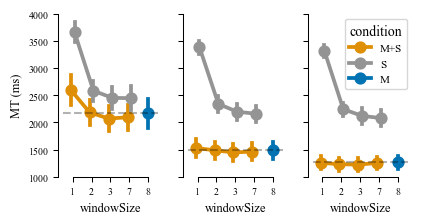

In [61]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 5))
set_figure_style(scale="1.5col")
# set_figure_style(scale="2col")

#get height of figure
fig = plt.figure()
fig.canvas.draw()
fig_height = fig.get_figheight()
fig_width = fig.get_figwidth()
fig.clear()
plt.close(fig)



fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_height * 3 / 4))

for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)].copy()
    subjs_correct = utils.remove_error_trials(subjs_sess)
    M_data = subjs_correct[subjs_correct['condition'] == 'M']

    #droping M_data from subjs_correct
    subjs_correct = subjs_correct[subjs_correct['condition'] != 'M']
    
    #create cartesian product to replicate data for each window size
    M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
    M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})


    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()

    M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()


    #for line plot change windowsizes range to 0 to 3
    # M_data_grouped['windowSize'] = M_data_grouped['windowSize'].replace([1, 2, 3, 7], np.array([0, 1, 2, 3]) - 0.1)

    # select only one window size so plot as one point
    M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
    M_data_grouped['windowSize'] = 8

    # sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
    #             palette=custom_palette, ax = axs[idx])
    
    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    # sns.lineplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition',
    #             palette=custom_palette, ax = axs[idx], legend=False, errorbar='se',
    #             )
    sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                palette=custom_palette, ax = axs[idx])

    axs[idx].hlines(M_data_grouped['MT'].mean(), -0.5, 4.5, color='black', linestyle='--', alpha = 0.3)

    if idx >0:
        axs[idx].set_ylabel('')
        #remove y axis tick labels
        axs[idx].set_yticklabels([])

    if idx <2 :
        #remove legend
        axs[idx].get_legend().remove()

    if idx == 0:
        # axs[idx].set_ylabel('Movement Time (ms)')
        axs[idx].set_ylabel('MT (ms)')


    axs[idx].set_ylim(1000, 4000)
    # axs[idx].set_title(f'Session {idx+1}')

    print(f"Session {idx+1} ANOVA", 
          AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['windowSize', 'condition']).fit())

    # paired t-test between consequtive window sizes
    condition_to_test = 'S'
    subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
    for i in range(len(windowSizes)-1):
        t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i]]['MT'],
                                subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i+1]]['MT'])
        print(f"Session {idx+1} paired t-test between window sizes {windowSizes[i]} and {windowSizes[i+1]}",
                f"t-stat: {t_stat}, p-value: {p_val}")
        
    # t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == 1]['MT'],
    #                     subjs_grouped[subjs_grouped['windowSize']> 1]['MT'])
    
        

        




sns.despine(trim=True)

plt.savefig(path_figs + "MT_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

In [63]:
subjs.columns

Index(['BN', 'TN', 'SubNum', 'hand', 'isTrain', 'symbol', 'cue', 'isMasked',
       'precueTime', 'windowSize', 'press1', 'press2', 'press3', 'press4',
       'press5', 'press6', 'press7', 'RT', 'ET', 'MT', 'isError',
       'timingError', 'points', 'response1', 'response2', 'response3',
       'response4', 'response5', 'response6', 'response7', 'handPressed1',
       'handPressed2', 'handPressed3', 'handPressed4', 'handPressed5',
       'handPressed6', 'handPressed7', 'pressTime1', 'pressTime2',
       'pressTime3', 'pressTime4', 'pressTime5', 'pressTime6', 'pressTime7',
       'timeThreshold', 'timeThresholdSuper', 'startTime', 'startTimeReal',
       'trialDur', 'startTR', 'startTRtime', 'useMetronome', 'isCross',
       'crossTime', 'IPI1', 'IPI2', 'IPI3', 'IPI4', 'IPI5', 'IPI6',
       'condition'],
      dtype='object')

In [78]:
print("****** ANOVA for MT across days and window sizes in S condition ******")
subjs_correct = utils.remove_error_trials(subjs).copy()
# select random sequences
subjs_correct = subjs_correct[subjs_correct['condition'].isin(['S'])]
# add day column 
subjs_correct['day'] = subjs_correct['BN'].apply(lambda x: 1 if x in session1_blocks else (2 if x in session2_blocks else 3))
subjs_grouped = subjs_correct.groupby(['day', 'SubNum', 'windowSize']).agg({
    'MT': 'median',
}).reset_index()

res = AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['day', 'windowSize']).fit()
print(res.anova_table)



print("****** ANOVA for MT in day 1 across window sizes in M+S condition ******")
subjs_correct = utils.remove_error_trials(subjs).copy()
# select repeating sequences
subjs_correct = subjs_correct[subjs_correct['condition'].isin(['M+S'])]
# filter day 1 
subjs_correct = subjs_correct[subjs_correct['BN'].isin(session1_blocks)]
subjs_grouped = subjs_correct.groupby(['SubNum', 'windowSize']).agg({
    'MT': 'median',
}).reset_index()
res = AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['windowSize']).fit()
print(res.anova_table)







****** ANOVA for MT across days and window sizes in S condition ******
                   F Value  Num DF  Den DF        Pr > F
day              14.905153     2.0    26.0  4.868177e-05
windowSize      302.955990     3.0    39.0  4.744508e-27
day:windowSize    0.262568     6.0    78.0  9.526277e-01
****** ANOVA for MT in day 1 across window sizes in M+S condition ******
              F Value  Num DF  Den DF        Pr > F
windowSize  16.481527     3.0    39.0  4.499988e-07


Session 1 ANOVA                        Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
windowSize           112.7562 3.0000 39.0000 0.0000
condition             44.5628 1.0000 13.0000 0.0000
windowSize:condition  25.9128 3.0000 39.0000 0.0000

Session 1 ANOVA M+S data                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
windowSize 16.4815 3.0000 39.0000 0.0000

Session 1 paired t-test between window sizes 1 and 2 t-stat: 4.541455127003109, p-value: 0.0005537088205942704
Session 1 paired t-test between window sizes 2 and 3 t-stat: 1.9373552474294022, p-value: 0.07473642892316591
Session 1 paired t-test between window sizes 3 and 7 t-stat: -0.6130611586988642, p-value: 0.5504113965429196

 Session 1 paired t-test between M and M+S conditions TtestResult(statistic=0.22278364015251917, pvalue=0.8271660765949777, df=13)
Session 2 ANOVA                        Anova
              

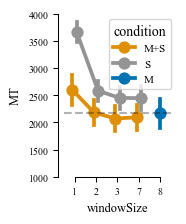

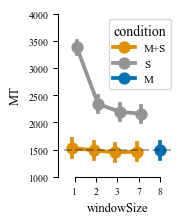

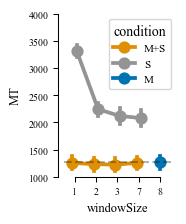

In [17]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 5))
set_figure_style(scale="1.5col")
# set_figure_style(scale="2col")


for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    #get height of figure
    fig = plt.figure()
    fig.canvas.draw()
    fig_height = fig.get_figheight()
    fig_width = fig.get_figwidth()
    fig.clear()
    # plt.close(fig)

    fig.set_size_inches(fig_width / 3, fig_height * 3 / 4)

    subjs_sess = subjs[subjs['BN'].isin(session)].copy()
    subjs_correct = utils.remove_error_trials(subjs_sess)
    M_data = subjs_correct[subjs_correct['condition'] == 'M']

    #droping M_data from subjs_correct
    subjs_correct = subjs_correct[subjs_correct['condition'] != 'M']
    
    #create cartesian product to replicate data for each window size
    M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
    M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})


    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()

    M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'MT': 'median'
    }).reset_index()


    #for line plot change windowsizes range to 0 to 3
    # M_data_grouped['windowSize'] = M_data_grouped['windowSize'].replace([1, 2, 3, 7], np.array([0, 1, 2, 3]) - 0.1)

    # select only one window size so plot as one point
    M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
    M_data_grouped['windowSize'] = 8

    # sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
    #             palette=custom_palette, ax = axs[idx])
    
    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette)
    # sns.lineplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition',
    #             palette=custom_palette, ax = axs[idx], legend=False, errorbar='se',
    #             )
    sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
                palette=custom_palette)

    plt.hlines(M_data_grouped['MT'].mean(), -0.5, 4.5, color='black', linestyle='--', alpha = 0.3)

    # if idx >0:
    #     axs[idx].set_ylabel('')
    #     #remove y axis tick labels
    #     axs[idx].set_yticklabels([])

    # if idx <2 :
    #     #remove legend
    #     axs[idx].get_legend().remove()

    # if idx == 0:
    #     # axs[idx].set_ylabel('Movement Time (ms)')
    #     axs[idx].set_ylabel('MT (ms)')


    # axs[idx].set_ylim(1000, 4000)
    # # axs[idx].set_title(f'Session {idx+1}')

    plt.ylim(1000, 4000)

    print(f"Session {idx+1} ANOVA", 
          AnovaRM(subjs_grouped, 'MT', 'SubNum', within=['windowSize', 'condition']).fit())
    
    print(f"Session {idx+1} ANOVA M+S data", 
          AnovaRM(subjs_grouped[subjs_grouped['condition'] == 'M+S'], 'MT', 'SubNum', within=['windowSize']).fit())

    # paired t-test between consequtive window sizes
    condition_to_test = 'M+S'
    subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
    for i in range(len(windowSizes)-1):
        t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i]]['MT'],
                                subjs_grouped[subjs_grouped['windowSize'] == windowSizes[i+1]]['MT'])
        print(f"Session {idx+1} paired t-test between window sizes {windowSizes[i]} and {windowSizes[i+1]}",
                f"t-stat: {t_stat}, p-value: {p_val}")
        
    # t_stat, p_val = stats.ttest_rel(subjs_grouped[subjs_grouped['windowSize'] == 1]['MT'],
    #                     subjs_grouped[subjs_grouped['windowSize']> 1]['MT'])




    # testing similarity of M+S and M conditions
    MS_data_grouped = subjs_correct[subjs_correct['condition'] == 'M+S'].groupby(['SubNum', 'condition']).agg({
        'MT': 'median'
    }).reset_index()
    print(f"\n Session {idx+1} paired t-test between M and M+S conditions",
          stats.ttest_rel(MS_data_grouped['MT'], M_data_grouped['MT']))
    
    
    sns.despine(trim=True)

    plt.savefig(path_figs + f"MT_windowSize_day{idx+1}.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

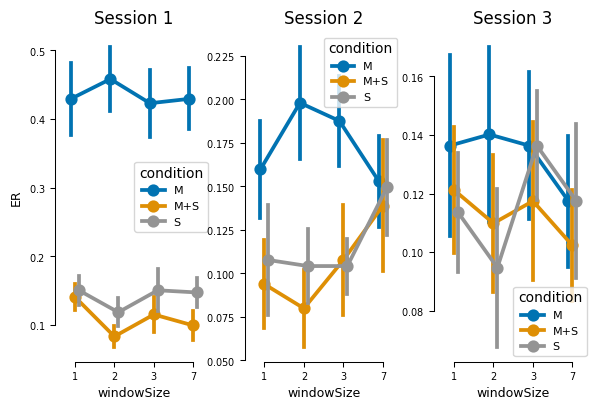

In [183]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 5))
set_figure_style(scale="2col")
fig, axs = plt.subplots(1, 3)
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)].copy()
    subjs_sess['#trial'] = 1

    subjs_grouped = subjs_sess.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'isError': 'sum',
        '#trial': 'count'
    }).reset_index()

    subjs_grouped['ER'] = subjs_grouped['isError']/ subjs_grouped['#trial']

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'ER', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    # axs[idx].set_ylim(1000, 4000)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.savefig(path_figs + "MT_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

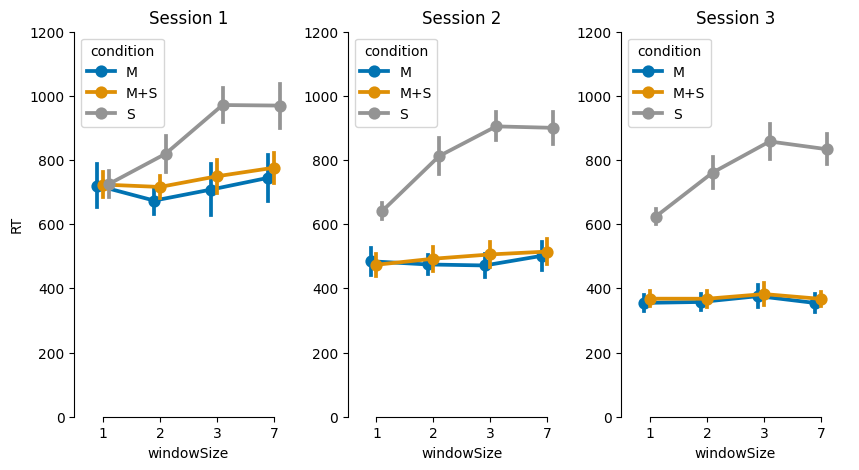

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs[subjs['BN'].isin(session)]
    subjs_correct = utils.remove_error_trials(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
        'RT': 'median'
    }).reset_index()

    sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'RT', hue = 'condition', errorbar='se',
                dodge = 0.2, palette=custom_palette, ax = axs[idx])
    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(0, 1200)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

plt.show()

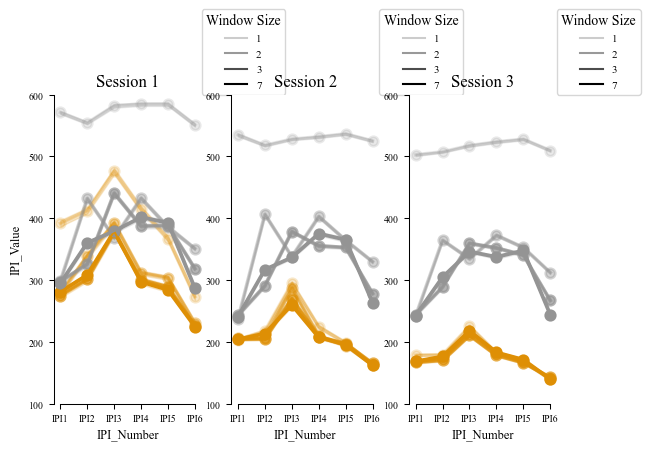

In [7]:
# fig, axs = plt.subplots(3, 1, figsize=(8, 25))
set_figure_style(scale="2col")
fig, axs = plt.subplots(1, 3, figsize=(rcParams["figure.figsize"][0], rcParams["figure.figsize"][1]))
line_styles = ['solid', 'dashdot', 'dashed', 'dotted']
alphas = [0.2, 0.4, 0.7, 1]
for idx, session in enumerate([session1_blocks, session2_blocks, session3_blocks]):
    subjs_sess = subjs_presses[subjs_presses['BN'].isin(session)]
    subjs_sess = subjs_sess[subjs_sess['condition'] != 'M']
    subjs_correct = utils.remove_error_trials_presses(subjs_sess)

    subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize', 'IPI_Number']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    for window_idx, window in enumerate(windowSizes):
        subjs_grouped_window = subjs_grouped[subjs_grouped['windowSize'] == window]
        # sns.pointplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar='se',
        #             dodge = 0.2, palette=custom_palette, ax = axs[idx], linestyles=line_styles[window_idx], legend=False)
        sns.pointplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar=None,
                    palette=custom_palette, ax = axs[idx], alpha = alphas[window_idx], legend=False)
        sns.lineplot(data = subjs_grouped_window, x = 'IPI_Number', y = 'IPI_Value', hue = 'condition', errorbar = ('se', 1/10),
                    palette=custom_palette, ax = axs[idx], alpha = alphas[window_idx])
        
        
    #create custom legend for the line styles
    # custom_lines = [plt.Line2D([0], [0], color='black', linestyle=line_styles[0]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[1]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[2]),
    #                 plt.Line2D([0], [0], color='black', linestyle=line_styles[3])]
    custom_lines = [plt.Line2D([0], [0], color='black', alpha = alphas[0]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[1]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[2]),
                    plt.Line2D([0], [0], color='black', alpha = alphas[3])]
    axs[idx].legend(custom_lines, windowSizes, title='Window Size', loc = (1, 1))
    
        

    

    if idx >0:
        axs[idx].set_ylabel('')

    axs[idx].set_ylim(100, 600)
    axs[idx].set_title(f'Session {idx+1}')
sns.despine(trim=True)

# plt.savefig(path_figs + "IPI_windowSize.pdf", format = 'pdf', bbox_inches = 'tight')

# plt.show()

In [9]:
import glob
import os
def movload(fname):
    # loads .mov files given the path of the file. The .mov files have a specific custom hence the need for a custom function
    A = []
    fid = open(fname, 'rt')
    if fid == -1:
        raise Exception('Could not open ' + fname)


    num_columns = None 

    trial = 0
    for line in fid:
        if line[0] == 'T':
            # print('Trial: ', line.split()[1])
            a = int(line.split()[1])
            trial += 1
            if a != trial:
                print('Trials out of sequence')
                trial = a
            A.append([])
            num_columns = None
            # A[trial-1] = np.empty((0,8))
        else:
            lineData = line.strip().split('\t')
            if num_columns is None:
                num_columns = len(lineData)
                A[trial - 1] = np.empty((0, num_columns))
            a = np.array([float(x) for x in lineData], ndmin=2)
            # print(a)
            A[trial-1] = np.vstack((A[trial-1],a))
            # A[trial-1].extend(a)

    fid.close()
    return A
pattern = utils.path +  "_*_*.mov"
files = glob.glob(pattern)
dfs = []
for file in files:
    filename = os.path.basename(file)

    parts = filename.split('_')

    if len(parts) >= 3:
        subnum = int(parts[1])
        block_number = int(parts[2].replace('.mov', ''))

        print(subnum, block_number)

        trials = movload(file)
        for trial_idx, trial in enumerate(trials):
            df = pd.DataFrame(trial, columns=['state',
                                              'timeReal', 'time',
                                              'force1R', 'force2R', 'force3R', 'force4R', 'force5R'])
            df['TN'] = trial_idx + 1
            df['BN'] = block_number
            df['SubNum'] = subnum
            dfs.append(df)
        

dfs = pd.concat(dfs)


# subjs_force = dfs.merge(subjs, on = ['SubNum' , 'BN', 'TN'], how='inner')

2 48
6 4
8 29
14 22
1 19
14 36
6 10
8 15
1 31
13 17
13 3
1 25
8 1
3 8
4 1
4 15
3 34
11 12
4 29
11 6
3 20
4 28
3 21
11 7
11 13
3 35
4 14
3 9
1 24
13 2
8 14
13 16
1 30
1 18
6 11
14 23
8 28
6 5
2 49
14 35
6 13
13 28
6 7
14 21
8 2
14 9
1 26
1 32
13 14
8 16
4 16
4 2
11 5
3 23
3 37
11 11
11 10
3 36
3 22
11 4
4 3
4 17
13 15
1 33
8 17
14 8
8 3
1 27
13 1
13 29
14 20
6 6
6 12
14 34
13 5
1 23
8 7
14 18
8 13
13 11
14 30
6 16
6 2
14 24
3 26
3 32
11 14
4 13
11 28
4 7
11 29
4 6
4 12
11 15
3 33
3 27
11 1
14 25
6 3
6 17
14 31
8 12
14 19
13 10
1 36
1 22
13 4
8 6
1 34
13 12
8 10
6 29
8 4
13 6
1 20
1 8
6 1
14 27
14 33
6 15
4 38
3 31
11 17
11 3
3 25
4 4
3 19
4 10
3 18
4 11
4 5
3 24
11 2
4 39
11 16
3 30
6 14
14 32
1 9
14 26
8 5
6 28
1 21
13 7
13 13
1 35
8 11
10 25
2 3
2 17
10 31
10 19
5 36
5 22
3 43
9 22
12 20
12 34
9 36
7 33
12 8
7 27
12 9
7 26
7 32
12 35
9 23
12 21
3 42
5 23
10 18
10 30
2 16
2 2
10 24
2 14
10 32
5 9
10 26
2 28
5 21
5 35
4 49
3 40
9 35
7 18
12 23
9 21
9 9
7 24
7 30
7 31
7 25
9 8
12 22
9 20

In [39]:
diffs[diffs < 4.9].index

Index([1133], dtype='int64')

In [45]:
trialdata

,state,timeReal,time,force1R,force2R,force3R,force4R,force5R,TN,BN,SubNum
0,3.0,2443455.047,0.0,0.151,0.054,0.097,0.165,0.076,24,36,14
1,3.0,2443460.045,5.0,0.150,0.050,0.097,0.161,0.077,24,36,14
2,3.0,2443465.049,10.0,0.151,0.059,0.090,0.164,0.073,24,36,14
3,3.0,2443470.044,15.0,0.146,0.055,0.097,0.162,0.076,24,36,14
4,3.0,2443475.044,20.0,0.148,0.052,0.099,0.161,0.070,24,36,14
...,...,...,...,...,...,...,...,...,...,...,...
1288,7.0,2449895.060,6440.0,0.021,0.002,0.180,0.289,0.088,24,36,14
1289,7.0,2449900.058,6445.0,0.025,0.005,0.186,0.295,0.087,24,36,14
1290,7.0,2449905.112,6450.0,0.029,-0.005,0.189,0.290,0.088,24,36,14
1291,7.0,2449910.047,6455.0,0.024,-0.006,0.178,0.288,0.092,24,36,14


In [46]:
diffs

0         NaN
1       4.998
2       5.004
3       4.995
4       5.000
        ...  
1288    5.003
1289    4.998
1290    5.054
1291    4.935
1292    5.003
Name: timeReal, Length: 1293, dtype: float64

In [49]:
diffs>10

0       False
1       False
2       False
3       False
4       False
        ...  
1397    False
1398    False
1399    False
1400    False
1401    False
Name: timeReal, Length: 1402, dtype: bool

Lower bound: 4.914999999979045, Upper bound: 5.084999999962747


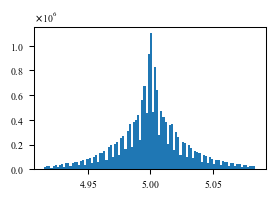

In [ ]:
## --- plotting time real increments in the data ----

diffs = []
# df_filtered = dfs[(dfs['SubNum'] == 1) & (dfs['BN'] == 10) & (dfs['TN'] == 1)]
for sub, subdata in dfs.groupby(['SubNum']):
    for block, blockdata in subdata.groupby(['BN']):
        for trial, trialdata in blockdata.groupby(['TN']):
            # diffs = np.append(diffs, trialdata['timeReal'].diff())
            diffs.extend(trialdata['timeReal'].diff().dropna())

diffs = np.array(diffs)
# diffs = diffs[(diffs > 0) & (diffs < 100)]
# print(diffs.shape)
# print(diffs)
# print(sorted(diffs)[:10])
# print(sorted(diffs)[-10:])

# 95 and 5 percentile
lower_bound = np.percentile(diffs, 1)
upper_bound = np.percentile(diffs, 99)
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

diffs = diffs[(diffs > lower_bound) & (diffs < upper_bound)]


plt.hist(diffs, bins=100)
# print(sorted(diffs)[-100:])
# print(sorted(diffs)[:100])
plt.show()

In [58]:
def plot_force(subjs_force, sub_num, block_num, trial_num):
    """
    Plot the force data for a given subject, block, and trial.
    
    Parameters:
        subjs_force (DataFrame): DataFrame containing force data.
        sub_num (int): Subject number.
        block_num (int): Block number.
        trial_num (int): Trial number.
    """
    df_filtered = subjs_force[(subjs_force['SubNum'] == sub_num) & (subjs_force['BN'] == block_num) & (subjs_force['TN'] == trial_num)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_filtered['time'],df_filtered['force1R'], label='Force 1R')
    plt.plot(df_filtered['time'],df_filtered['force2R'], label='Force 2R')
    plt.plot(df_filtered['time'],df_filtered['force3R'], label='Force 3R')
    plt.plot(df_filtered['time'],df_filtered['force4R'], label='Force 4R')
    plt.plot(df_filtered['time'],df_filtered['force5R'], label='Force 5R')
    
    plt.xlabel('Time')
    plt.ylabel('Force')
    plt.title(f'Subject {sub_num}, Block {block_num}, Trial {trial_num}')
    plt.legend()
    plt.show()

In [61]:
# df_filtered = dfs[(dfs['SubNum'] == 1) & (dfs['BN'] == 10) & (dfs['TN'] == 1)]
for sub, subdata in dfs.groupby(['SubNum']):
    for block, blockdata in subdata.groupby(['BN']):
        for trial, trialdata in blockdata.groupby(['TN']):
            # diffs = np.append(diffs, trialdata['timeReal'].diff())
            diffs = trialdata['timeReal'].diff()
            # return index of diffs greater than 10 if any
            if diffs[diffs > 10].any():
                print("****************")
                print(f"SubNum: {sub}, BN: {block}, TN: {trial}")
                print(trialdata[diffs > 10])
                print(diffs[diffs > 10])

****************
SubNum: (1,), BN: (1,), TN: (1,)
     state    timeReal   time  force1R  force2R  force3R  force4R  force5R  \
177    4.0  195463.221  885.0   -0.059   -0.101   -0.003    0.005   -0.085   

     TN  BN  SubNum  
177   1   1       1  
177    13.148
Name: timeReal, dtype: float64
****************
SubNum: (1,), BN: (26,), TN: (21,)
     state    timeReal    time  force1R  force2R  force3R  force4R  force5R  \
985    6.0  369098.744  4925.0   -0.022   -0.018   -0.056   -0.026   -0.164   

     TN  BN  SubNum  
985  21  26       1  
985    8393.675
Name: timeReal, dtype: float64
****************
SubNum: (2,), BN: (25,), TN: (1,)
     state   timeReal   time  force1R  force2R  force3R  force4R  force5R  TN  \
196    4.0  151385.41  980.0   -0.064    -0.01    0.003   -0.054   -0.097   1   

     BN  SubNum  
196  25       2  
196    15.38
Name: timeReal, dtype: float64
****************
SubNum: (3,), BN: (13,), TN: (1,)
     state    timeReal   time  force1R  force2R  force3R 

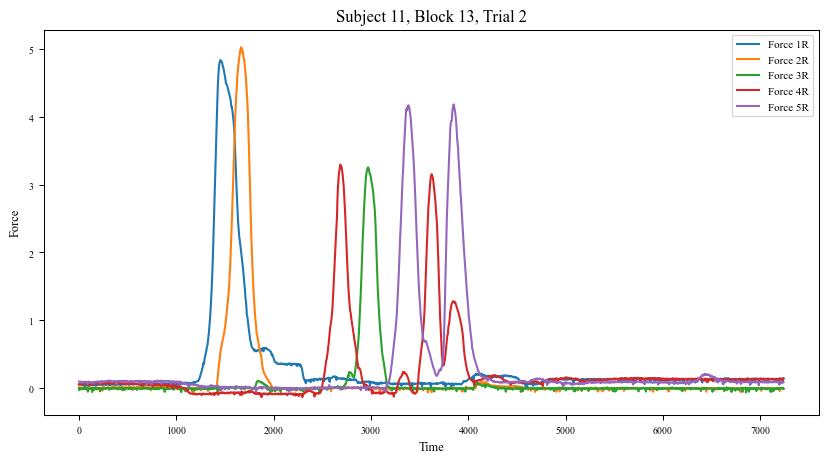

In [64]:
plot_force(dfs, 11, 13, 2)